In [1]:
import matplotlib
matplotlib.rc("lines", linewidth=2)
matplotlib.rc('text', usetex=True)
matplotlib.rc("font", family="serif", serif='cmr10')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpower import *

In [3]:
periods_per_hour = 60
T = 24*periods_per_hour
len_interval=1/periods_per_hour
p_load = np.array([
  0.51474725,
  0.47401232,
  0.46804122,
  0.47140148,
  0.51735674,
  0.63193182,
  0.80121667,
  0.74983225,
  0.71661753,
  0.74235491,
  0.73155551,
  0.70865584,
  0.67823632,
  0.66232903,
  0.68180769,
  0.77185203,
  0.94758236,
  1.0033142 ,
  1.02072008,
  1.16801152,
  1.30939302,
  1.11789843,
  0.8708018 ,
  0.62076654 ])
N = p_load.size
p_load = np.interp(np.arange(T), np.linspace(0,T,N), p_load)
p_load = p_load / np.max(p_load)

load = FixedLoad(power=p_load, name='fixed load')
gen = Generator(power_max=6, alpha=.05*len_interval, beta=0, name="generator")
deferrable = DeferrableLoad(time_start=8*periods_per_hour, time_end=20*periods_per_hour, energy=20, 
                            power_max=5, len_interval=len_interval, name="def. load")
storage = Storage(discharge_max=2, charge_max=2, energy_max=5, len_interval=len_interval, name='storage')
net = Net([gen.terminals[0], deferrable.terminals[0],
           load.terminals[0], storage.terminals[0]])

network = Group([gen, deferrable, load, storage], [net])
network.optimize(time_horizon=T, verbose=True, solver="ECOS")

/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:614: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:615: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2



ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.120e-16  -3.085e+04  +7e+04  3e-01  4e-01  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +6.087e+00  -8.749e+03  +3e+04  8e-02  2e-02  2e+00  3e+00  0.7181  2e-01   1  1  1 |  0  0
 2  +9.733e+00  -1.488e+03  +6e+03  1e-02  8e-03  4e-01  6e-01  0.9890  2e-01   1  1  1 |  0  0
 3  +1.015e+01  -4.275e+01  +2e+02  4e-04  2e-03  1e-02  2e-02  0.9659  4e-03   1  1  1 |  0  0
 4  +4.571e+00  -2.036e+00  +3e+01  6e-05  5e-04  1e-03  3e-03  0.8856  2e-02   1  1  1 |  0  0
 5  +3.318e+00  +5.057e-01  +1e+01  2e-05  2e-04  5e-04  1e-03  0.6891  2e-01   1  1  1 |  0  0
 6  +2.967e+00  +1.512e+00  +7e+00  1e-05  1e-04  2e-04  6e-04  0.6140  2e-01   1  1  1 |  0  0
 7  +2.960e+00  +1.524e+00  +7e+00  1e-05  1e-04  2e-04  6e-04  0.0691  8e-01   1  1  1 |  0  0
 8  +2.828e+00  +2.001e+00  +4e+00  7e-06  8e-

Status: optimal
Terminal                  Power
--------                  -----
def. load[0]               0.83
storage[0]                 0.00
generator[0]              -1.42
fixed load[0]              0.59

Net                       Price
---                       -----
Net                      0.0024

Terminal                Payment
--------                  -----
def. load[0]               0.00
storage[0]                -0.00
generator[0]              -0.00
fixed load[0]              0.00

All values above are averages over the time horizon.

In [4]:
for d in network.devices:
    for t in d.terminals:
        print(d.name, ': ', t.payment.sum())

generator :  -5.37762687293174
def. load :  3.738830277931505
fixed load :  2.037448807937827
storage :  -0.3986522129375927


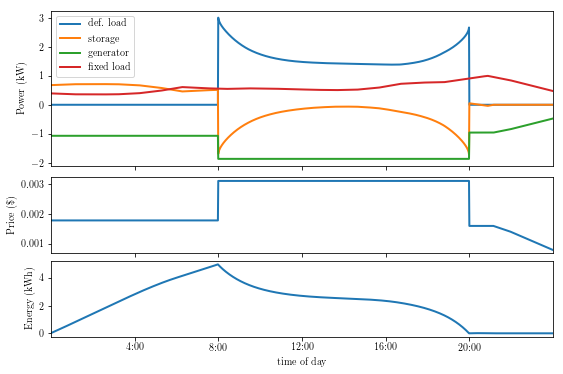

In [5]:
plt.figure(figsize=(9,6))

ticks = [t*periods_per_hour for t in [4,8,12,16,20]]
plt.subplot(211)
i = network.results.power.items()
for (d, pd) in i:
    plt.plot(pd)
plt.legend([d[0].name for (d,pd) in i], loc='upper left')
plt.ylabel("Power (kW)")
plt.xlim([0,T])
#.ylim([-2,4.5])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(413)
plt.plot(list(network.results.price.items())[0][1])
plt.ylabel("Price (\$)")
plt.xlim([0,T])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(414)
plt.plot(storage.energy.value)
plt.ylabel("Energy (kWh)")
plt.xlabel("time of day")
plt.xlim([0,T])
plt.subplots_adjust(hspace=.1)

plt.xticks(ticks, ('4:00', '8:00', '12:00', '16:00', '20:00'))

plt.savefig("home_energy_results.pdf")